In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, StructType, BooleanType, ArrayType
import pyspark
import pyspark.sql.functions as f
from pyspark.sql.functions import *
from pyspark.sql.functions import struct
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
import re
import ipaddress
from ipaddress import ip_network, ip_address
import time
import pandas as pd
import seaborn as sns
#import envspark

#Starten ohne Spark-Cluster
spark = SparkSession.builder.getOrCreate()

In [3]:
# Verbindung zu Minio
spark.sparkContext.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.access.key", "minio")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "minio123")
spark.sparkContext._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "http://minio1:9000")

In [4]:
schema = StructType([
    StructField("Top level domain", StringType(), True),
    StructField("MX-Record from the name server", StringType(), True),
    StructField("A-Record of the specific domain", StringType(), True),
    StructField("Timestamp", StringType(), True)])

df = spark.read.csv("s3a://bucket/real_new.csv",header=False,sep=";",schema=schema).persist()

# Datenbeschreibung

## real_domains

### Allgemein

In [5]:
df.show(5)

+----------------+------------------------------+-------------------------------+-------------------+
|Top level domain|MX-Record from the name server|A-Record of the specific domain|          Timestamp|
+----------------+------------------------------+-------------------------------+-------------------+
|         0--1.de|          "[""mail.0--1.de"...|           "[""46.38.249.145...|2020-12-13 15:36:05|
|         0--2.de|          "[""mxf993.netcup...|           "[""212.227.212.1...|2020-12-13 15:36:05|
|    0-0-0-0-0.de|          "[""smtp-02.tld.t...|           "[""80.150.6.143""]"|2020-12-13 15:36:05|
|      0-0-0-1.de|          "[""smtp-02.tld.t...|           "[""80.150.6.143""]"|2020-12-13 15:36:05|
|          0-0.de|                            []|           "[""185.53.178.13...|2020-12-13 15:36:05|
+----------------+------------------------------+-------------------------------+-------------------+
only showing top 5 rows



* Top level domain: Namensserver; das, was Personen sich merken können
* Ein MX Resource Record weist einem Namen einen Mailserver zu. Er stellt eine Besonderheit dar, da er sich auf einen speziellen Dienst im Internet, nämlich die E-Mailzustellung mittels SMTP, bezieht. Alle anderen Dienste nutzen CNAME, A und AAAA Resource Records für die Namensauflösung.
* Ein A Resource Record weist einem Namen eine IPv4-Adresse zu.

In [6]:
df= df.withColumn("id", monotonically_increasing_id())

In [7]:
df=df.select("Top level domain","MX-Record from the name server","A-Record of the specific domain")

* die Spalte Timestamp wird nicht benötigt

In [8]:
df=df.withColumnRenamed("MX-Record from the name server", "MX-Record")

In [9]:
df=df.withColumnRenamed("A-Record of the specific domain", "A-Record")

In [10]:
type(df)

pyspark.sql.dataframe.DataFrame

In [11]:
df.count()

4860885

In [12]:
df.dropDuplicates().count()

4860885

* es gibt keine Duplikate in dem Datensatz

In [15]:
df.printSchema()

root
 |-- Top level domain: string (nullable = true)
 |-- MX-Record: string (nullable = true)
 |-- A-Record: string (nullable = true)



In [16]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------------+---------+--------+
|Top level domain|MX-Record|A-Record|
+----------------+---------+--------+
|               0|        0|       0|
+----------------+---------+--------+



### Top Level Domain

In [17]:
df.filter(df["Top level domain"]=="null").count()

0

* keine Null Values

In [18]:
dfTCount=df.groupBy("Top level domain").count()
dfTCount.orderBy(col("count").desc()).show(5)

+--------------------+-----+
|    Top level domain|count|
+--------------------+-----+
|      0-provision.de|    1|
|         01041977.de|    1|
|0180-call-through.de|    1|
|            03423.de|    1|
|            03g17.de|    1|
+--------------------+-----+
only showing top 5 rows



* es gibt keine doppelte TLD

### MX Records

In [19]:
df.filter(df["MX-Record"]=="null").count()

0

* keine Null Values

In [20]:
dfMxCount=df.groupBy("MX-Record").count()
dfMxCount.orderBy(col("count").desc()).show(5,False)

+-----------------------------------------------------+------+
|MX-Record                                            |count |
+-----------------------------------------------------+------+
|[]                                                   |633040|
|"[""smtpin.rzone.de""]"                              |509127|
|"[""localhost""]"                                    |303839|
|"[""mx01.kundenserver.de"",""mx00.kundenserver.de""]"|176491|
|"[""mx00.kundenserver.de"",""mx01.kundenserver.de""]"|176182|
+-----------------------------------------------------+------+
only showing top 5 rows



### A Records

In [21]:
df.filter(df["A-Record"]=="null").count()

10732

* es gibt 10.732 Null Values
* diese können mit [] ersetzt werde

In [22]:
df=df.na.replace({"null": "[]"})

In [23]:
dfACount=df.groupBy("A-Record").count()
dfACount.orderBy(col("count").desc()).show(5, False)

+----------------------+------+
|A-Record              |count |
+----------------------+------+
|"[""91.195.241.137""]"|303204|
|[]                    |172019|
|"[""80.150.6.143""]"  |150156|
|"[""23.236.62.147""]" |59034 |
|"[""52.58.78.16""]"   |49200 |
+----------------------+------+
only showing top 5 rows



## asn ip4 Blocks

In [24]:
schema_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("autonomous_system_number", IntegerType(), True),
    StructField("autonomous_system_organization", StringType(), True)
])

df_asn_blocks_ipv4 = spark.read.csv("s3a://bucket/GeoLite2-ASN-Blocks-IPv4.csv", header=True, schema=schema_blocks).persist()

In [25]:
df_asn_blocks_ipv4.show(5)

+------------+------------------------+------------------------------+
|     network|autonomous_system_number|autonomous_system_organization|
+------------+------------------------+------------------------------+
|  1.0.0.0/24|                   13335|                 CLOUDFLARENET|
|  1.0.4.0/22|                   38803|          Wirefreebroadband...|
| 1.0.64.0/18|                   18144|          Energia Communica...|
|1.0.128.0/17|                   23969|          TOT Public Compan...|
|  1.1.1.0/24|                   13335|                 CLOUDFLARENET|
+------------+------------------------+------------------------------+
only showing top 5 rows



In [26]:
df_asn_blocks_ipv4.count()

461902

In [27]:
df_asn_blocks_ipv4.dropDuplicates().count()

461902

* es gibt keine Duplikate in dem Datensatz

In [28]:
df_asn_blocks_ipv4.printSchema()

root
 |-- network: string (nullable = true)
 |-- autonomous_system_number: integer (nullable = true)
 |-- autonomous_system_organization: string (nullable = true)



In [29]:
df_asn_blocks_ipv4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_asn_blocks_ipv4.columns]).show()

+-------+------------------------+------------------------------+
|network|autonomous_system_number|autonomous_system_organization|
+-------+------------------------+------------------------------+
|      0|                       0|                             0|
+-------+------------------------+------------------------------+



## GeoLite2-Country-Locations-en

In [30]:
schema_country = StructType([
    StructField("geoname_id", IntegerType(), True),
    StructField("locale_code", StringType(), True),
    StructField("continent_code", StringType(), True),
    StructField("continent_name", StringType(), True),
    StructField("country_iso_code", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("is_in_european_union", StringType(), True)
])

df_country = spark.read.csv("s3a://bucket/GeoLite2-Country-Locations-en.csv", header=True, schema=schema_country).persist()

In [31]:
df_country.show(5)

+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|     49518|         en|            AF|        Africa|              RW|      Rwanda|                   0|
|     51537|         en|            AF|        Africa|              SO|     Somalia|                   0|
|     69543|         en|            AS|          Asia|              YE|       Yemen|                   0|
|     99237|         en|            AS|          Asia|              IQ|        Iraq|                   0|
|    102358|         en|            AS|          Asia|              SA|Saudi Arabia|                   0|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
only showing top 5 rows



In [32]:
df_country.printSchema()

root
 |-- geoname_id: integer (nullable = true)
 |-- locale_code: string (nullable = true)
 |-- continent_code: string (nullable = true)
 |-- continent_name: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- is_in_european_union: string (nullable = true)



In [33]:
df_country.count()

252

In [34]:
df_country.dropDuplicates().count()

252

* es gibt keine Duplikate in dem Datensatz

In [35]:
df_country.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_country.columns]).show()

+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|         0|          0|             0|             0|               2|           2|                   0|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+



* keine Null Values

### Unbenötigte Spalten im Datensatz asn ip4 country entfernen 

In [36]:
df_country = df_country.drop("locale_code", "continent_code", "continent_name", "country_iso_code", "is_in_european_union")

In [37]:
df_country.show()

+----------+--------------------+
|geoname_id|        country_name|
+----------+--------------------+
|     49518|              Rwanda|
|     51537|             Somalia|
|     69543|               Yemen|
|     99237|                Iraq|
|    102358|        Saudi Arabia|
|    130758|                Iran|
|    146669|              Cyprus|
|    149590|            Tanzania|
|    163843|               Syria|
|    174982|             Armenia|
|    192950|               Kenya|
|    203312|            DR Congo|
|    223816|            Djibouti|
|    226074|              Uganda|
|    239880|Central African R...|
|    241170|          Seychelles|
|    248816|              Jordan|
|    272103|             Lebanon|
|    285570|              Kuwait|
|    286963|                Oman|
+----------+--------------------+
only showing top 20 rows



# GeoLite2-Country-Blocks-IPv4

In [52]:
schema_country_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("geoname_id", IntegerType(), True),
    StructField("registered_country_geoname_id", IntegerType(), True),
    StructField("represented_country_geoname_id", IntegerType(), True),
    StructField("is_anonymous_proxy", StringType(), True),
    StructField("is_satellite_provider", StringType(), True)
])

df_country_blocks = spark.read.csv("s3a://bucket/GeoLite2-Country-Blocks-IPv4.csv", header=True, schema=schema_country_blocks).persist()

In [53]:
df_country_blocks.show(5)

+----------+----------+-----------------------------+------------------------------+------------------+---------------------+
|   network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+----------+----------+-----------------------------+------------------------------+------------------+---------------------+
|1.0.0.0/24|   2077456|                      2077456|                          null|                 0|                    0|
|1.0.1.0/24|   1814991|                      1814991|                          null|                 0|                    0|
|1.0.2.0/23|   1814991|                      1814991|                          null|                 0|                    0|
|1.0.4.0/22|   2077456|                      2077456|                          null|                 0|                    0|
|1.0.8.0/21|   1814991|                      1814991|                          null|                 0|               

In [54]:
df_country_blocks.count()

334879

In [55]:
df_country_blocks.dropDuplicates().count()

334879

* es gibt keine Duplikate in diesem Datensatz

In [56]:
df_country_blocks.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_country_blocks.columns]).show()

+-------+----------+-----------------------------+------------------------------+------------------+---------------------+
|network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+
|      0|      1909|                          783|                        334697|                 0|                    0|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+



* es gibt häufiger Null-Werte in diesem Datensatz. Dies ist der Grund warum in der späteren Analyse weniger Datensätze zur Verfügung stehen als in dem Domain Datensatz

In [57]:
df_country_blocks.printSchema()

root
 |-- network: string (nullable = true)
 |-- geoname_id: integer (nullable = true)
 |-- registered_country_geoname_id: integer (nullable = true)
 |-- represented_country_geoname_id: integer (nullable = true)
 |-- is_anonymous_proxy: string (nullable = true)
 |-- is_satellite_provider: string (nullable = true)



# Data Cleaning

## Entfernen von Sonderzeichen im Datensatz real Domains

In [114]:
commaRep = udf(lambda x: re.sub('"','', x))
commaRep2 = udf(lambda x: re.sub(']','', x))
commaRep3 = udf(lambda x: re.sub('\[','', x))
commaRep5 = udf(lambda x: re.sub('\.','', x))

In [115]:
df_MXClean=df.withColumn('MX-Record',commaRep('MX-Record'))
df_MXClean=df_MXClean.withColumn('MX-Record',commaRep2('MX-Record'))
df_MXClean=df_MXClean.withColumn('MX-Record',commaRep3('MX-Record'))
df_MXClean.show(3, False)

+----------------+-----------------------------------------------+-----------------------+
|Top level domain|MX-Record                                      |A-Record               |
+----------------+-----------------------------------------------+-----------------------+
|0--1.de         |mail.0--1.de,mxf993.netcup.net                 |"[""46.38.249.145""]"  |
|0--2.de         |mxf993.netcup.net,mail.0--2.de                 |"[""212.227.212.163""]"|
|0-0-0-0-0.de    |smtp-02.tld.t-online.de,smtp-01.tld.t-online.de|"[""80.150.6.143""]"   |
+----------------+-----------------------------------------------+-----------------------+
only showing top 3 rows



In [60]:
df_AClean=df.withColumn('A-Record',commaRep('A-Record'))
df_AClean=df_AClean.withColumn('A-Record',commaRep2('A-Record'))
df_AClean=df_AClean.withColumn('A-Record',commaRep3('A-Record'))
df_AClean.show(3, False)

+----------------+-----------------------------------------------------------+---------------+
|Top level domain|MX-Record                                                  |A-Record       |
+----------------+-----------------------------------------------------------+---------------+
|0--1.de         |"[""mail.0--1.de"",""mxf993.netcup.net""]"                 |46.38.249.145  |
|0--2.de         |"[""mxf993.netcup.net"",""mail.0--2.de""]"                 |212.227.212.163|
|0-0-0-0-0.de    |"[""smtp-02.tld.t-online.de"",""smtp-01.tld.t-online.de""]"|80.150.6.143   |
+----------------+-----------------------------------------------------------+---------------+
only showing top 3 rows



 ## Splitten der Spalten im Datensatz real_domains

In [274]:
df_MXSplit=df_MXClean.select(
        "Top level domain", "A-Record",
        f.split("MX-Record", ",").alias("MX-Record"),
        f.posexplode(f.split("MX-Record", ",")).alias("pos_MX", "val_MX")
    )
df_MXSplit.show(20)

+----------------+--------------------+--------------------+------+--------------------+
|Top level domain|            A-Record|           MX-Record|pos_MX|              val_MX|
+----------------+--------------------+--------------------+------+--------------------+
|         0--1.de|"[""46.38.249.145...|[mail.0--1.de, mx...|     0|        mail.0--1.de|
|         0--1.de|"[""46.38.249.145...|[mail.0--1.de, mx...|     1|   mxf993.netcup.net|
|         0--2.de|"[""212.227.212.1...|[mxf993.netcup.ne...|     0|   mxf993.netcup.net|
|         0--2.de|"[""212.227.212.1...|[mxf993.netcup.ne...|     1|        mail.0--2.de|
|    0-0-0-0-0.de|"[""80.150.6.143""]"|[smtp-02.tld.t-on...|     0|smtp-02.tld.t-onl...|
|    0-0-0-0-0.de|"[""80.150.6.143""]"|[smtp-02.tld.t-on...|     1|smtp-01.tld.t-onl...|
|      0-0-0-1.de|"[""80.150.6.143""]"|[smtp-02.tld.t-on...|     0|smtp-02.tld.t-onl...|
|      0-0-0-1.de|"[""80.150.6.143""]"|[smtp-02.tld.t-on...|     1|smtp-01.tld.t-onl...|
|          0-0.de|"["

In [209]:
df_MXSplit.printSchema()

root
 |-- Top level domain: string (nullable = true)
 |-- A-Record: string (nullable = true)
 |-- MX-Record: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pos_MX: integer (nullable = false)
 |-- val_MX: string (nullable = true)
 |-- domain: string (nullable = true)



In [206]:
df_ASplit=df_AClean.select(
        "Top level domain", "MX-Record",
        f.split("A-Record", ", ").alias("A-Record"),
        f.posexplode(f.split("A-Record", ",")).alias("pos_A", "val_A")
    )
df_ASplit.show(20)

+-------------------+--------------------+-----------------+-----+---------------+
|   Top level domain|           MX-Record|         A-Record|pos_A|          val_A|
+-------------------+--------------------+-----------------+-----+---------------+
|            0--1.de|"[""mail.0--1.de"...|  [46.38.249.145]|    0|  46.38.249.145|
|            0--2.de|"[""mxf993.netcup...|[212.227.212.163]|    0|212.227.212.163|
|       0-0-0-0-0.de|"[""smtp-02.tld.t...|   [80.150.6.143]|    0|   80.150.6.143|
|         0-0-0-1.de|"[""smtp-02.tld.t...|   [80.150.6.143]|    0|   80.150.6.143|
|             0-0.de|                  []|  [185.53.178.13]|    0|  185.53.178.13|
|            0-01.de|"[""mail.0-01.de""]"| [193.34.145.200]|    0| 193.34.145.200|
|             0-1.de|   "[""localhost""]"| [91.195.241.137]|    0| 91.195.241.137|
|            0-10.de|                  []|               []|    0|               |
|          0-1000.de|   "[""localhost""]"| [91.195.241.137]|    0| 91.195.241.137|
|   

In [208]:
df_ASplit.count()

5540060

In [66]:
#für den späteren Join müssen diese Null Werte entfernt werden. 
#Im MX Datensatz wird kein Join benötigt, weshalb die Null Werte dort erhalen bleiben.
df_ASplit=df_ASplit.filter(df_ASplit.val_A!="")

In [67]:
df_ASplit.count()

5368041

In [68]:
df_ASplit.printSchema()

root
 |-- Top level domain: string (nullable = true)
 |-- MX-Record: string (nullable = true)
 |-- A-Record: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pos_A: integer (nullable = false)
 |-- val_A: string (nullable = true)



# Joining

## Joining von Tabelle real_new und asn_blocks_ipv4

In [82]:
def ip_range(ip, network_range):
    return ipaddress.IPv4Address(str(ip)) in ipaddress.ip_network(str(network_range))

pred = udf(lambda ip, network_range:ipaddress.IPv4Address(str(ip)) in ipaddress.ip_network(str(network_range)), BooleanType())

In [83]:
startzeit=time.time()

* Auswahl der ersten 2000 Daten aus dem ursprünglichen Datensatz

In [85]:
#Für eine Analyse des ganzen Datensatzes verwendet man
#dfJoinATest=df_ASplit
#anstatt der folgenden Zeile


dfJoinATest=df_ASplit.limit(2000)

In [88]:
dfJoinA=dfJoinATest.join(df_asn_blocks_ipv4,how="right").where(pred(dfJoinATest.val_A, df_asn_blocks_ipv4.network)).cache()

In [ ]:
dfJoinA.show()

In [89]:
zeitende=time.time()

In [90]:
(zeitende-startzeit)/60

0.03683681488037109

## Joining von dfjoinA mit df_city_blocks

In [92]:
df_joint_JoinA_mitBlocks = dfJoinA\
            .join(df_country_blocks, dfJoinA["network"] == df_country_blocks["network"])

In [93]:
df_joint_JoinA_mitBlocks.show(5)

+----------------+--------------------+--------------+-----+------------+-------------+------------------------+------------------------------+--------------+------------+-------------+----------+-----------------------------+------------------------------+------------------+---------------------+
|Top level domain|           MX-Record|      A-Record|pos_A|       val_A|      network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|      network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+----------------+--------------------+--------------+-----+------------+-------------+------------------------+------------------------------+--------------+------------+-------------+----------+-----------------------------+------------------------------+------------------+---------------------+
|  01759354151.de|"[""mx.0175935415...|  [2.56.97.57]|    0|  2.56.97.57| 2.56.96.0/22|                

## Joining der Blocks mit den Ländern

In [94]:
df_joint_all = df_joint_JoinA_mitBlocks\
            .join(df_country, df_joint_JoinA_mitBlocks["geoname_id"] == df_country["geoname_id"])

In [95]:
df_joint_all.show(5)

+----------------+--------------------+--------------+-----+------------+-------------+------------------------+------------------------------+--------------+------------+-------------+----------+-----------------------------+------------------------------+------------------+---------------------+----------+------------+
|Top level domain|           MX-Record|      A-Record|pos_A|       val_A|      network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|      network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|geoname_id|country_name|
+----------------+--------------------+--------------+-----+------------+-------------+------------------------+------------------------------+--------------+------------+-------------+----------+-----------------------------+------------------------------+------------------+---------------------+----------+------------+
|  01759354151.de|"[""mx.017593

## Checken Joining-Datensatz

In [91]:
dfJoinA.count()

1997

In [96]:
df_joint_JoinA_mitBlocks.count()

684

In [97]:
df_joint_all.count()

684

* bei unseren gejointen Netzwerken scheinen überproportional viele unbekannte Länder dabei zu sein

# Analyse

* die Analyse wurde teilweise mit dem kompletten und teilweise mit dem gejointen begrenzten Datensatz durchgeführt
* bei Analysen mit dem berenzten Datensatz wurden 2000 Werte genutzt und daraufhin die Ergebnisse ermittelt
* durch die Joins bedeutet das es wurde entweder mit 1997 oder 684 Datensätzen gearbeitet
* dies bedeutet die Ergebnisse könnten von einer Analyse mit dem kompletten Datensatz abweichen

In [234]:
sns.set_theme(style="whitegrid")
sns.set_palette("tab10")

## How many A records does a top level domain usually have?

* Analyse mit: dem gesamten Datensatz

In [211]:
df_ASplit_Grouped=df_ASplit.groupBy("Top level domain").count()
df_ASplit_Grouped.orderBy(col("count").desc()).show(20, False)


+--------------------------+-----+
|Top level domain          |count|
+--------------------------+-----+
|def-service.de            |20   |
|bnw-music.de              |20   |
|contentchoice.de          |20   |
|def-platform.de           |20   |
|content-choice.de         |20   |
|addefend-platform.de      |20   |
|ourschoolnet.de           |16   |
|harmlessnoize.de          |16   |
|berlinsbi.de              |15   |
|chunksofco.de             |13   |
|lasthit.de                |12   |
|politischer-hintergrund.de|12   |
|frozenice.de              |12   |
|remotees.de               |12   |
|skablog.de                |12   |
|aktion-mensch.de          |12   |
|dickens-lesen.de          |12   |
|gott-im-abseits.de        |12   |
|infrastructureasco.de     |12   |
|winewonder.de             |12   |
+--------------------------+-----+
only showing top 20 rows



In [212]:
df_ASplit_Grouped.describe().show()

+-------+----------------+------------------+
|summary|Top level domain|             count|
+-------+----------------+------------------+
|  count|         4860885|           4860885|
|   mean|            null|1.1397224990922434|
| stddev|            null|0.5434283628481107|
|    min|         0--1.de|                 1|
|    max|   zzzzzzzzzz.de|                20|
+-------+----------------+------------------+



* die meisten Top Level Domains haben nur ein A-record

Text(0.5, 1.1, 'Häufigkeit der Anzahl der A-Records pro Top Level Domain')

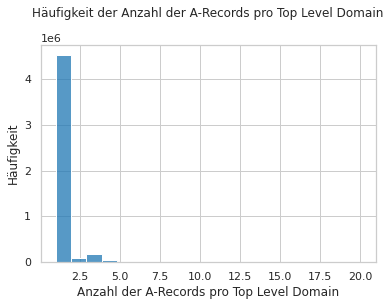

In [235]:
Adf_pandas_all = df_ASplit_Grouped.toPandas()
g=sns.histplot(data=Adf_pandas_all, x="count",bins=20)
g.set(xlabel="Anzahl der A-Records pro Top Level Domain",ylabel="Häufigkeit")
g.set_title("Häufigkeit der Anzahl der A-Records pro Top Level Domain",y=1.1)

* auch hier wird deutlich, dass extrem viele Top Level Domains nur ein A-Record haben

Text(0.5, 1.1, 'Häufigkeit der Anzahl der A-Records pro Top Level Domain (>1)')

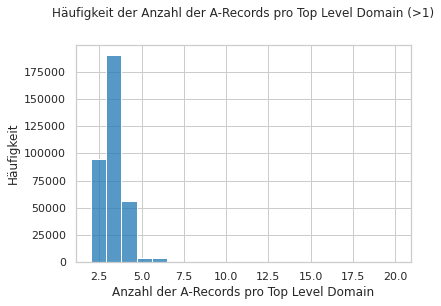

In [236]:
df_ASplit_Grouped_high=df_ASplit_Grouped.filter(df_ASplit_Grouped["count"]>1)
Adf_pandas_high = df_ASplit_Grouped_high.toPandas()
g=sns.histplot(data=Adf_pandas_high, x="count",bins=20)
g.set(xlabel="Anzahl der A-Records pro Top Level Domain",ylabel="Häufigkeit")
g.set_title("Häufigkeit der Anzahl der A-Records pro Top Level Domain (>1)",y=1.1)

* nimmt man alle Domains mit nur einem A-Record aus der Visualisierung heraus erkennt man, dass bis zu 5 Records manchmal vorkommen, alles darüber jedoch extrem selten ist

## Which A- Records are used?


* Analyse mit: dem gesamten Datensatz

In [300]:
email_provider=df_ASplit.groupBy("val_A").agg(f.count('*')).withColumnRenamed("count(1)", "count")
email_provider=email_provider.withColumn("percent", (col("count") / df_ASplit.count())*100 )
email_provider.orderBy(col("count(1)").desc()).show(10, False)

+--------------+------+------------------+
|val_A         |count |percent           |
+--------------+------+------------------+
|91.195.241.137|303205|5.472955166550543 |
|              |172019|3.1050024728974055|
|80.150.6.143  |150197|2.711107821936946 |
|23.236.62.147 |59295 |1.070295267560279 |
|54.171.90.223 |51534 |0.9302065320592195|
|52.48.64.111  |51532 |0.9301704313671694|
|52.58.78.16   |49200 |0.8880770244365584|
|81.169.145.143|42000 |0.7581145330555987|
|54.229.198.190|38567 |0.696147695151316 |
|52.50.104.40  |38566 |0.6961296448052909|
+--------------+------+------------------+
only showing top 10 rows



* rund 3% der Datensätze haben keine E-Mail Provider
* dies ist die 2. größte Gruppe

In [301]:
email_provider_p=email_provider.toPandas()

In [302]:
email_provider_p.head()

,val_A,count,percent
0,89.22.102.214,192,0.003466
1,185.53.177.14,3626,0.065451
2,85.13.152.182,43,0.000776
3,172.67.213.49,9,0.000162
4,85.13.131.69,80,0.001444


In [303]:
email_provider_p.count()

val_A      420904
count      420904
percent    420904
dtype: int64

In [304]:
email_provider_p["count"].mean()

13.162288787942144

* ein MX-Record kommt durchnittlich 5x im Datensatz vor

Text(0.5, 1.1, 'Häufigkeit der Anzahl eines Datensatzes')

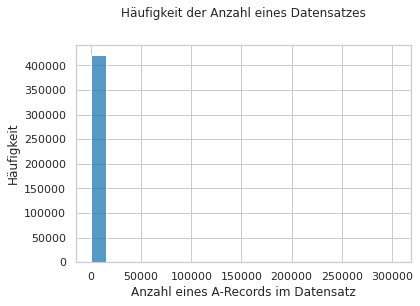

In [306]:
g=sns.histplot(data=email_provider_p, x="count",bins=20)
g.set(xlabel="Anzahl eines A-Records im Datensatz",ylabel="Häufigkeit")
g.set_title("Häufigkeit der Anzahl eines Datensatzes", y=1.1)

* hier ist kaum etwas erkennbar, da die alles meisten A-Records nur sehr selten vorkommen

Text(0.5, 1.1, 'Häufigkeit der Anzahl eines A-Records im Datensatz')

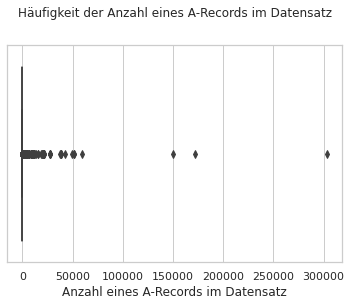

In [307]:
g=sns.boxplot(data=email_provider_p,x="count")
g.set(xlabel="Anzahl eines A-Records im Datensatz")
g.set_title("Häufigkeit der Anzahl eines A-Records im Datensatz", y=1.1)

* hier sieht man, dass es einige Ausreißer im Datensatz gibt

## What are the Top 10 Companies that own the servers the A records point to?


* Analyse mit: dem begrenzten Datensatz (1997)

In [100]:
top_companies=dfJoinA.groupBy("autonomous_system_organization").count()
top_companies=top_companies.orderBy(col("count").desc()).limit(10)
top_companies.show(20,False)

+------------------------------+-----+
|autonomous_system_organization|count|
+------------------------------+-----+
|SEDO GmbH                     |714  |
|CLOUDFLARENET                 |162  |
|Hetzner Online GmbH           |127  |
|Strato AG                     |108  |
|1&1 Ionos Se                  |92   |
|Neue Medien Muennich GmbH     |84   |
|AMAZON-02                     |78   |
|Host Europe GmbH              |63   |
|netcup GmbH                   |54   |
|Deutsche Telekom AG           |45   |
+------------------------------+-----+



* die am häufigsten vorkommende Organisation ist die SEDO GmbH

Text(0.5, 1.1, 'Häufigkeit der Anzahl einer Organisation')

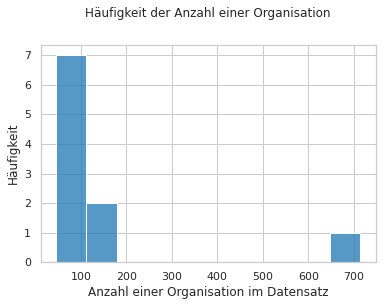

In [239]:
top_companies_p=top_companies.toPandas()
g=sns.histplot(data=top_companies_p, x="count",bins=10)
g.set(xlabel="Anzahl einer Organisation im Datensatz",ylabel="Häufigkeit")
g.set_title("Häufigkeit der Anzahl einer Organisation",y=1.1)

* nur SEDO kommt sehr häufig vor

Text(0.5, 1.1, 'What are the Top 10 Companies that own the servers the A records point to?')

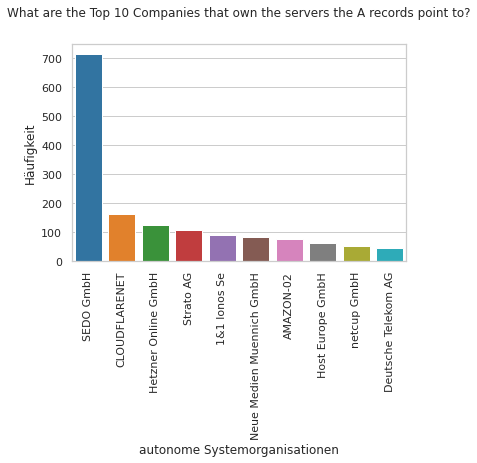

In [242]:
g=sns.barplot(data=top_companies_p,x="autonomous_system_organization",y="count")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set(xlabel="autonome Systemorganisationen",ylabel="Häufigkeit")
g.set_title("What are the Top 10 Companies that own the servers the A records point to?",y=1.1)

## Where are these companys located?

* Analyse mit: dem berenzten Datensatz (1997)

In [262]:
top_locate=df_joint_all.join(top_companies,"autonomous_system_organization","right").select("autonomous_system_organization","country_name","count").distinct().sort(desc("count"))
top_locate=top_locate.na.fill("no Country",["country_name"])
top_locate.show()

+------------------------------+-------------+-----+
|autonomous_system_organization| country_name|count|
+------------------------------+-------------+-----+
|                     SEDO GmbH|   no Country|  714|
|                 CLOUDFLARENET|   no Country|  162|
|           Hetzner Online GmbH|      Finland|  127|
|           Hetzner Online GmbH|      Germany|  127|
|                     Strato AG|      Germany|  108|
|                  1&1 Ionos Se|      Germany|   92|
|          Neue Medien Muenn...|      Germany|   84|
|                     AMAZON-02|United States|   78|
|                     AMAZON-02|      Germany|   78|
|                     AMAZON-02|      Ireland|   78|
|              Host Europe GmbH|      Germany|   63|
|              Host Europe GmbH|       France|   63|
|                   netcup GmbH|      Germany|   54|
|           Deutsche Telekom AG|      Germany|   45|
+------------------------------+-------------+-----+



In [245]:
top_locate_p=top_locate.toPandas()

Text(0.5, 1.1, 'Top 10 Companies that own the servers the A records point to, location of A-record IPs')

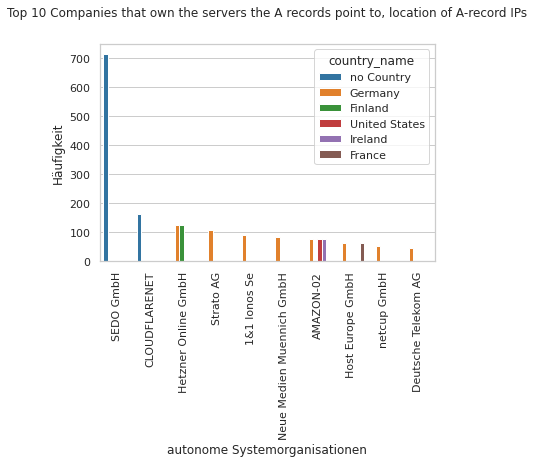

In [246]:
g=sns.barplot(x="autonomous_system_organization",y="count",hue="country_name",data=top_locate_p)
g.set(xlabel="autonome Systemorganisationen",ylabel="Häufigkeit")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Top 10 Companies that own the servers the A records point to, location of A-record IPs", y=1.1)

* die großten Firmen haben A-Records in Deutschland, Finland, USA, Irland und Frankreich
* die meisten Standorte sind jedoch unbekannt

## How many websites use Cloudflare?


* Analyse mit: dem begrenzten Datensatz (1997)

In [106]:
dfJoinA.filter(dfJoinA.autonomous_system_organization=='CLOUDFLARENET').show()


+------------------+--------------------+--------------------+-----+-------------+--------------+------------------------+------------------------------+--------------+------------+
|  Top level domain|           MX-Record|            A-Record|pos_A|        val_A|       network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+------------------+--------------------+--------------------+-----+-------------+--------------+------------------------+------------------------------+--------------+------------+
|   030hoodmerch.de|"[""mx01.ionos.de...|      [23.227.38.32]|    0| 23.227.38.32|23.227.38.0/23|                   13335|                 CLOUDFLARENET|   23.227.38.0|          23|
|   069-clothing.de|"[""mx.069-clothi...|      [23.227.38.72]|    0| 23.227.38.72|23.227.38.0/23|                   13335|                 CLOUDFLARENET|   23.227.38.0|          23|
|    0711-gaming.de|"[""w015c1e6.kass...|      [23.227.38.65]|    0| 23.227.38.65|23.227.3

In [107]:
dfJoinA.filter(dfJoinA.autonomous_system_organization=='CLOUDFLARENET').count()


162

* 162 von 2000 Domains nutzen Cloudflare

## How many German websites use German hosting providers?


* Analyse mit: dem begrenzten Datensatz (684)

In [256]:
dfcountry=df_joint_all.select("Top level domain","country_name")

In [257]:
dfcountry.count()

684

In [258]:
dfcountryCount=dfcountry.groupBy("country_name").count()
dfcountryCount.orderBy(col("count").desc()).show(5,False)

+------------+-----+
|country_name|count|
+------------+-----+
|Germany     |528  |
|France      |54   |
|Ireland     |36   |
|Denmark     |20   |
|Austria     |11   |
+------------+-----+
only showing top 5 rows



* diese Analyse bezieht sich auf die A-Records. Um sie auf die Websites zu beziehen müssen die Dublikate der Top Level Domains entfernt werden

In [260]:
dfCountryDrop=dfcountry.dropDuplicates()
dfCountryDrop.count()

662

In [263]:
dfCountryDropCount=dfCountryDrop.groupBy("country_name").count()
dfCountryDropCount=dfCountryDropCount.withColumn("percent", (col("count") / 662)*100 )
dfCountryDropCount.orderBy(col("count").desc()).show(5,False)

+------------+-----+------------------+
|country_name|count|percent           |
+------------+-----+------------------+
|Germany     |524  |79.15407854984893 |
|France      |54   |8.157099697885197 |
|Ireland     |22   |3.3232628398791544|
|Denmark     |20   |3.0211480362537766|
|Austria     |11   |1.6616314199395772|
+------------+-----+------------------+
only showing top 5 rows



* 524 von 662 Websiten haben einen deutschen Hosting Provider. Dies entspricht einem Anteil von fast 80 %

## From which countries are the other Hosting-Providers?

* Analyse mit: dem begrenzten Datensatz (684)

In [264]:
df_joint_all_nongerman=df_joint_all.filter(df_joint_all.country_name!="Germany")
countries_hosting=df_joint_all_nongerman.groupBy("country_name").count()
countries_hosting.show(20,False)

+--------------------+-----+
|country_name        |count|
+--------------------+-----+
|France              |54   |
|Finland             |2    |
|United States       |10   |
|Denmark             |20   |
|Ireland             |36   |
|Switzerland         |8    |
|United Arab Emirates|1    |
|Australia           |3    |
|Romania             |1    |
|Austria             |11   |
|Hungary             |1    |
|United Kingdom      |2    |
|Netherlands         |7    |
+--------------------+-----+



In [279]:
countries_hosting=countries_hosting.withColumn("percent", (col("count") / df_joint_all.count())*100 )
countries_hosting=countries_hosting.orderBy(col("count").desc())
countries_hosting.show(20,False) 

+--------------------+-----+-------------------+
|country_name        |count|percent            |
+--------------------+-----+-------------------+
|France              |54   |7.894736842105263  |
|Ireland             |36   |5.263157894736842  |
|Denmark             |20   |2.923976608187134  |
|Austria             |11   |1.608187134502924  |
|United States       |10   |1.461988304093567  |
|Switzerland         |8    |1.1695906432748537 |
|Netherlands         |7    |1.023391812865497  |
|Australia           |3    |0.43859649122807015|
|Finland             |2    |0.29239766081871343|
|United Kingdom      |2    |0.29239766081871343|
|United Arab Emirates|1    |0.14619883040935672|
|Romania             |1    |0.14619883040935672|
|Hungary             |1    |0.14619883040935672|
+--------------------+-----+-------------------+



* Nach Deutschland kommen die meisten Hosting Provider aud Frankreich, Irland und Dänemark

In [267]:
countries_hosting_p=countries_hosting.toPandas()

Text(0.5, 1.1, 'Häufigkeit mit welcher eine Wesite einen Hosting Provider aus einem Land nutzt')

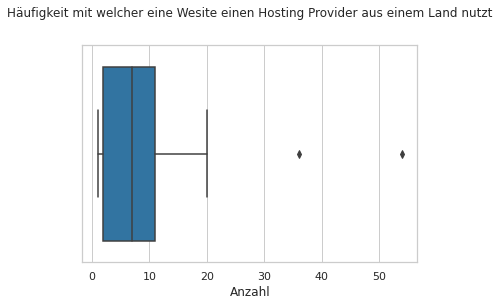

In [286]:
g=sns.boxplot(data=countries_hosting_p,x="count")
g.set(xlabel="Anzahl")
g.set_title("Häufigkeit mit welcher eine Wesite einen Hosting Provider aus einem Land nutzt", y=1.1)

## How many MX records does a top level domain usually have?

* Analyse mit: dem gesamten Datensatz

In [308]:
df_MXSplit_Grouped=df_MXSplit.groupBy("Top level domain").count()
df_MXSplit_Grouped.orderBy(col("count").desc()).show(5, False)

+--------------------+-----+
|Top level domain    |count|
+--------------------+-----+
|domservice.de       |21   |
|derproviderserver.de|18   |
|liebesort.de        |17   |
|redleadsmarketing.de|16   |
|mysmartshop.de      |16   |
+--------------------+-----+
only showing top 5 rows



In [309]:
df_MXSplit_Grouped.describe().show()

+-------+----------------+------------------+
|summary|Top level domain|             count|
+-------+----------------+------------------+
|  count|         4860885|           4860885|
|   mean|            null|1.4506329608702941|
| stddev|            null|0.7938619534327868|
|    min|         0--1.de|                 1|
|    max|   zzzzzzzzzz.de|                21|
+-------+----------------+------------------+



* die meisten Top Level Domains haben nur ein MX Record

Text(0.5, 1.1, 'Häufigkeit der Anzahl der MX-Records pro Top Level Domain')

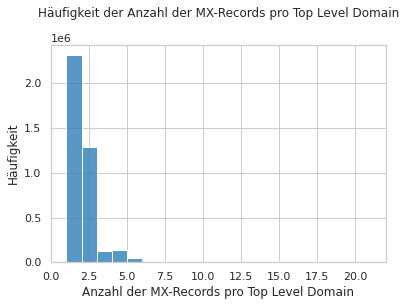

In [237]:
MXdf_pandas_all = df_MXSplit_Grouped.toPandas()
g=sns.histplot(data=MXdf_pandas_all, x="count",bins=20)
g.set(xlabel="Anzahl der MX-Records pro Top Level Domain",ylabel="Häufigkeit")
g.set_title("Häufigkeit der Anzahl der MX-Records pro Top Level Domain",y=1.1)

* auch hier wird deutlich, dass extrem viele Top Level Domains nur ein MX-Record haben

Text(0.5, 1.1, 'Häufigkeit der Anzahl der MX-Records pro Top Level Domain (>1)')

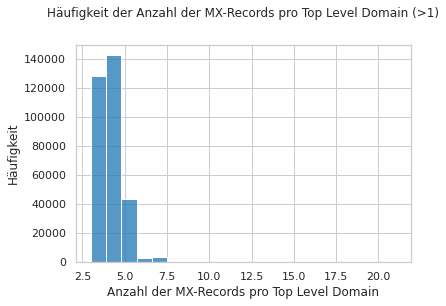

In [238]:
df_MXSplit_Grouped_high=df_MXSplit_Grouped.filter(df_MXSplit_Grouped["count"]>2)
MXdf_pandas_high = df_MXSplit_Grouped_high.toPandas()
g=sns.histplot(data=MXdf_pandas_high, x="count",bins=20)
g.set(xlabel="Anzahl der MX-Records pro Top Level Domain",ylabel="Häufigkeit")
g.set_title("Häufigkeit der Anzahl der MX-Records pro Top Level Domain (>1)",y=1.1)

* nimmt man alle Domains mit nur einem MX-Record aus der Visualisierung heraus erkennt man, dass bis zu 6 Records manchmal vorkommen, alles darüber jedoch extrem selten ist

## Which email provider are used (MX record)?


* Analyse mit: dem gesamten Datensatz

In [278]:
email_provider=df_MXSplit.groupBy("val_MX").agg(f.count('*')).withColumnRenamed("count(1)", "count")
email_provider=email_provider.withColumn("percent", (col("count") / df_MXSplit.count())*100 )
email_provider.orderBy(col("count(1)").desc()).show(10, False)

+-----------------------+------+------------------+
|val_MX                 |count |percent           |
+-----------------------+------+------------------+
|                       |634443|8.997455809943046 |
|smtpin.rzone.de        |509331|7.223159787615439 |
|mx01.kundenserver.de   |359139|5.093187697125093 |
|mx00.kundenserver.de   |358404|5.082764175988745 |
|localhost              |303841|4.308970184475052 |
|mx1.jimdo.com          |162813|2.308958839145924 |
|mx2.jimdo.com          |162795|2.3087035692405435|
|mx00.ionos.de          |156544|2.2200540037666494|
|mx01.ionos.de          |156482|2.2191747407592293|
|smtp-02.tld.t-online.de|150254|2.130851353497765 |
+-----------------------+------+------------------+
only showing top 10 rows



* rund 9% der Datensätze haben keine E-Mail Provider
* dies ist die größte Gruppe

In [280]:
email_provider_p=email_provider.toPandas()

In [281]:
email_provider_p.head()

,val_MX,count,percent
0,mx1.webhoster.de,2622,0.037184
1,mail.0815club.de,1,0.000014
2,mail.0x40.de,1,0.000014
3,mail.0x777.de,1,0.000014
4,mail.1-vp.de,1,0.000014


In [282]:
email_provider_p.count()

val_MX     1322702
count      1322702
percent    1322702
dtype: int64

In [283]:
email_provider_p["count"].mean()

5.331026943332663

* ein MX-Record kommt durchnittlich 5x im Datensatz vor

Text(0.5, 1.1, 'Häufigkeit der Anzahl eines Datensatzes')

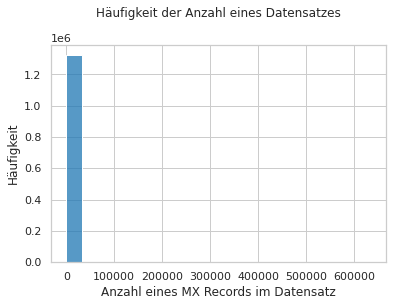

In [284]:
g=sns.histplot(data=email_provider_p, x="count",bins=20)
g.set(xlabel="Anzahl eines MX-Records im Datensatz",ylabel="Häufigkeit")
g.set_title("Häufigkeit der Anzahl eines Datensatzes", y=1.1)

* hier ist kaum etwas erkennbar, da die alles meisten MX-Records nur sehr selten vorkommen

Text(0.5, 1.1, 'Häufigkeit der Anzahl eines MX_Records im Datensatz')

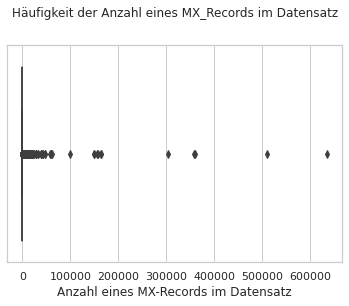

In [287]:
g=sns.boxplot(data=email_provider_p,x="count")
g.set(xlabel="Anzahl eines MX-Records im Datensatz")
g.set_title("Häufigkeit der Anzahl eines MX-Records im Datensatz", y=1.1)

* hier sieht man, dass es einige Ausreißer im Datensatz gibt

## Which Domains are used by the MX-Records?

* Analyse mit: dem gesamten Datensatz

In [289]:
email_provider_p["domain"] = email_provider_p['val_MX'].str.rsplit('.',1).str[-1]

In [290]:
email_provider_p.head()

,val_MX,count,percent,domain
0,mx1.webhoster.de,2622,0.037184,de
1,mail.0815club.de,1,0.000014,de
2,mail.0x40.de,1,0.000014,de
3,mail.0x777.de,1,0.000014,de
4,mail.1-vp.de,1,0.000014,de


In [296]:
value_counts=email_provider_p["domain"].value_counts()

email_domain_count = pd.DataFrame(value_counts)
email_domain_count = email_domain_count.reset_index()
email_domain_count.columns = ['domain', 'count'] # change column names
email_domain_count

,domain,count
0,de,963785
1,com,331606
2,net,8168
3,eu,2471
4,org,2142
...,...,...
715,farm,1
716,dx,1
717,center,1
718,jobs,1


In [297]:
email_domain_count.count()

domain    720
count     720
dtype: int64

Text(0.5, 1.1, 'Häufigkeit der Domains im Datensatz')

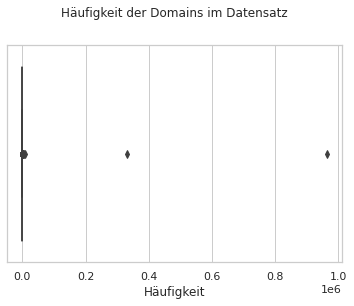

In [294]:
g=sns.boxplot(data=email_domain_count,x="count")
g.set(xlabel="Häufigkeit")
g.set_title("Häufigkeit der Domains im Datensatz", y=1.1)

* die Domains de und com überwiegen in diesem Datensatz

In [201]:
email_domain_count[email_domain_count["count"]>1].count()

domain    504
count     504
dtype: int64

* nur 504 von 720 Domains sind häufiger als 1x vorhanden

Text(0.5, 1.1, 'Top 10 Domains')

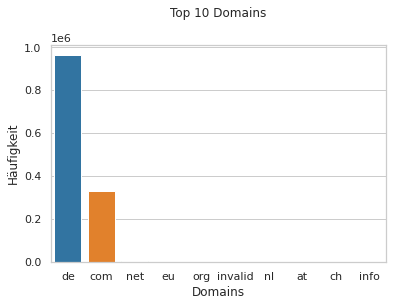

In [298]:
g= sns.barplot(data=email_domain_count[:10],x="domain",y="count")
g.set(xlabel="Domains",ylabel="Häufigkeit")
g.set_title("Top 10 Domains", y=1.1)